In [3]:
# LSTM МОДЕЛЬ
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Визначення шляху до набору даних
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
dataset_path = os.path.join(desktop_path, 'UkrPoems_MiniDataset.csv')

# Завантаження набору даних
poems_df = pd.read_csv(dataset_path, encoding='utf-8')
print(poems_df.columns)
num_rows, num_columns = poems_df.shape
print("\nРозмір набору даних: {} рядків і {} стовпців".format(num_rows, num_columns))
missing_values = poems_df.isnull().sum()
print("Кількість відсутніх значень у стовпцях:")
print(missing_values)
print("\nТипи стовпців:")
print(poems_df.dtypes)

# Попередня обробка тексту
texts = " ".join(poems_df['Вірш'].tolist())
texts = texts.replace('\ufeff', '').lower()  # Перетворення на нижній регістр
texts = texts.replace('\n', ' ')  # Замінювання нових рядків на пробіли

# Токенізація
maxWordsCount = 2000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&()*+,-./:;<=>?@[\]^`{|}~\t\n\r«»', lower=True, split=' ')
tokenizer.fit_on_texts([texts])

data = tokenizer.texts_to_sequences([texts])
data = np.array(data[0])
print(data[:10])  # Виведення перших 10 токенів для перевірки

# Створення вхідних та вихідних послідовностей
inp_words = 3
n = data.shape[0] - inp_words
X = np.array([data[i:i + inp_words] for i in range(n)])
Y = data[inp_words:]

# Зменшення використання пам'яті шляхом обробки партіями
batch_size = 5000
X_batches = [X[i:i + batch_size] for i in range(0, X.shape[0], batch_size)]
Y_batches = [Y[i:i + batch_size] for i in range(0, Y.shape[0], batch_size)]

# Архітектура моделі "Генерація тексту"
model = Sequential()
model.add(Embedding(input_dim=maxWordsCount, output_dim=128, input_length=inp_words, trainable=True))
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
model.add(LayerNormalization())
model.add(Dropout(0.4))
model.add(LSTM(64, activation='tanh'))
model.add(LayerNormalization())
model.add(Dense(maxWordsCount, activation='softmax'))

# Побудова моделі з використанням фіктивного вводу
model.build(input_shape=(None, inp_words))
model.summary()

# Компіляція моделі
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0005, clipnorm=1.0))

# Розділення на навчальний та валідаційний набори
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Колбеки
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Навчання моделі партіями
epochs_per_batch = 2
total_epochs = 50
history_list = []  # Для збереження історії навчання


for epoch in range(total_epochs):
    print(f"Епоха {epoch + 1}/{total_epochs}")
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        Y_batch = to_categorical(Y_batch, num_classes=maxWordsCount)
        history = model.fit(X_batch, Y_batch, batch_size=64, epochs=epochs_per_batch, callbacks=[reduce_lr, early_stop], validation_data=(X_val, to_categorical(Y_val, num_classes=maxWordsCount)))
        history_list.append(history.history)

# Об'єднання історій навчання для всіх партій
history_combined = {key: [value for batch in history_list for value in batch[key]] for key in history_list[0]}          
                
# Функція генерації тексту
def buildPhrase(seed_text, str_len=20):
    result = seed_text
    data = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Якщо початковий текст занадто короткий, доповнити нулями
    if len(data) < inp_words:
        data = [0] * (inp_words - len(data)) + data

    for _ in range(str_len):
        x = data[-inp_words:]
        x = np.expand_dims(x, axis=0)
        
        pred = model.predict(x)
        next_index = pred.argmax(axis=1)[0]
        data.append(next_index)
        
        next_word = tokenizer.index_word.get(next_index, '')
        result += " " + next_word

    return result

# Генерація продовження для заданого початкового тексту
res = buildPhrase("Мені однаково", str_len=20)


# --------------------------------------------------------------------------------------------------------------


# Модель аналізу настрою
# Попередня обробка тексту для аналізу настрою
poems_df['Настрій'] = poems_df['Настрій'].map({'Позитивний': 'positive', 'Негативний': 'negative'})
poems_df.dropna(subset=['Вірш'], inplace=True)

maxWordsCount_sent = 2000
tokenizer_sent = Tokenizer(num_words=maxWordsCount_sent, filters='', lower=True, split=' ')
tokenizer_sent.fit_on_texts(poems_df['Вірш'])

max_text_len = 20
X_sent = pad_sequences(tokenizer_sent.texts_to_sequences(poems_df['Вірш']), maxlen=max_text_len)

# Підготовка міток
Y_sent = to_categorical(poems_df['Настрій'].map({'positive': 0, 'negative': 1}).values, num_classes=2)

# Розділення на навчальний та валідаційний набори для аналізу настрою
X_train_sent, X_val_sent, Y_train_sent, Y_val_sent = train_test_split(X_sent, Y_sent, test_size=0.1, random_state=42)

# Архітектура моделі для аналізу настрою
sent_model = Sequential()
sent_model.add(Embedding(maxWordsCount_sent, 128, input_length=max_text_len))
sent_model.add(Bidirectional(LSTM(128, return_sequences=True)))
sent_model.add(LayerNormalization())
sent_model.add(Dropout(0.5))
sent_model.add(LSTM(64))
sent_model.add(LayerNormalization())
sent_model.add(Dropout(0.5))
sent_model.add(Dense(2, activation='softmax'))

# Побудова моделі для аналізу настрою з використанням фіктивного вводу
sent_model.build(input_shape=(None, max_text_len))
sent_model.summary()

# Компіляція моделі для аналізу настрою
sent_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

# Колбеки для аналізу настрою
reduce_lr_sent = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop_sent = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Навчання моделі для аналізу настрою
history_sent = sent_model.fit(X_train_sent, Y_train_sent, batch_size=64, epochs=50, validation_data=(X_val_sent, Y_val_sent), callbacks=[reduce_lr_sent, early_stop_sent])

# Функція аналізу настрою
reverse_word_map_sent = dict(map(reversed, tokenizer_sent.word_index.items()))

def sequence_to_text(list_of_indices):
    words = [reverse_word_map_sent.get(index, '') for index in list_of_indices]
    return ' '.join(words)

def analyze_sentiment(text):
    data = tokenizer_sent.texts_to_sequences([text])
    data_pad = pad_sequences(data, maxlen=max_text_len)
    
    res = sent_model.predict(data_pad)
    sentiment = np.argmax(res)
    
    if sentiment == 0:
        return "Позитивний"
    else:
        return "Негативний"

# Аналіз настрою згенерованого тексту
res_sent = analyze_sentiment(res)

print("Вірш:", res)
print("Настрій:", res_sent)

Index(['Автор', 'Назва', 'Вірш', 'Настрій'], dtype='object')

Розмір набору даних: 100 рядків і 4 стовпців
Кількість відсутніх значень у стовпцях:
Автор      0
Назва      0
Вірш       0
Настрій    0
dtype: int64

Типи стовпців:
Автор      object
Назва      object
Вірш       object
Настрій    object
dtype: object
[   6   11  460  679 1318    2   90   71  122   18]


C:\Users\Vika\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 3, 128)              │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 3, 256)              │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_8                │ (None, 3, 256)              │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_9                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2000)                │         130,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 731,984 (2.79 MB)

 Trainable params: 731,984 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

Епоха 1/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0181 - loss: 7.4421 - val_accuracy: 0.0485 - val_loss: 6.8076 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0502 - loss: 6.5806 - val_accuracy: 0.0562 - val_loss: 6.5334 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0473 - loss: 6.8273 - val_accuracy: 0.0628 - val_loss: 6.4150 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0600 - loss: 6.3610 - val_accuracy: 0.0706 - val_loss: 6.2340 - learning_rate: 5.0000e-04
Епоха 2/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0703 - loss: 6.2429 - val_accuracy: 0.0838 - val_loss: 5.9511 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1002 - loss: 5.8027 - val_accuracy: 0.1290 - val_loss: 5.7002 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8830 - loss: 0.6749 - val_accuracy: 0.9217 - val_loss: 0.5459 - learning_rate: 5.0000e-04
Епоха 12/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8397 - loss: 0.8404 - val_accuracy: 0.9195 - val_loss: 0.4666 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9176 - loss: 0.5003 - val_accuracy: 0.9085 - val_loss: 0.4779 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8637 - loss: 0.7686 - val_accuracy: 0.9261 - val_loss: 0.4669 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9207 - loss: 0.5175 - val_accuracy: 0.9151 - val_loss: 0.4677 - learning_rate: 5.0000e-04
Епоха 13/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8737 - loss: 0.6684 - val_accuracy: 0.9228 - val_loss: 0.4039 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9330 

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9326 - loss: 0.3251 - val_accuracy: 0.9724 - val_loss: 0.1005 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9646 - loss: 0.1984 - val_accuracy: 0.9757 - val_loss: 0.1021 - learning_rate: 5.0000e-04
Епоха 23/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9507 - loss: 0.2336 - val_accuracy: 0.9791 - val_loss: 0.1057 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9690 - loss: 0.1579 - val_accuracy: 0.9779 - val_loss: 0.1171 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9424 - loss: 0.2946 - val_accuracy: 0.9802 - val_loss: 0.0968 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9651 - loss: 0.1957 - val_accuracy: 0.9768 - val_loss: 0.1040 - learning_rate: 5.0000e-04
Епоха 24/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9565 

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9747 - loss: 0.0997 - val_accuracy: 0.9813 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9612 - loss: 0.1770 - val_accuracy: 0.9868 - val_loss: 0.0458 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9730 - loss: 0.1172 - val_accuracy: 0.9868 - val_loss: 0.0494 - learning_rate: 5.0000e-04
Епоха 34/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9704 - loss: 0.1260 - val_accuracy: 0.9824 - val_loss: 0.0559 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9768 - loss: 0.0963 - val_accuracy: 0.9802 - val_loss: 0.0620 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9619 - loss: 0.1657 - val_accuracy: 0.9835 - val_loss: 0.0459 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9743 - loss: 0.11

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9733 - loss: 0.1050 - val_accuracy: 0.9868 - val_loss: 0.0409 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9763 - loss: 0.0787 - val_accuracy: 0.9824 - val_loss: 0.0513 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9670 - loss: 0.1184 - val_accuracy: 0.9846 - val_loss: 0.0381 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9725 - loss: 0.0999 - val_accuracy: 0.9868 - val_loss: 0.0361 - learning_rate: 5.0000e-04
Епоха 45/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9699 - loss: 0.1098 - val_accuracy: 0.9835 - val_loss: 0.0470 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9748 - loss: 0.0855 - val_accuracy: 0.9857 - val_loss: 0.0399 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9698 - loss: 0.12

C:\Users\Vika\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 20, 128)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 20, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_10               │ (None, 20, 256)             │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_11               │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 602,114 (2.30 MB)

 Trainable params: 602,114 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.5749 - loss: 1.0683 - val_accuracy: 0.6000 - val_loss: 0.8892 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5957 - loss: 0.9869 - val_accuracy: 0.6000 - val_loss: 0.8311 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6602 - loss: 0.7566 - val_accuracy: 0.6000 - val_loss: 0.8334 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6306 - loss: 0.9064 - val_accuracy: 0.6000 - val_loss: 0.8394 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6358 - loss: 0.7675 - val_accuracy: 0.6000 - val_loss: 0.8737 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6928 - loss: 0.8159 - val_accuracy: 0.6000 - val_loss: 0.8971 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7106 - loss: 0.586

In [1]:
# GRU МОДЕЛЬ
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GRU, Dropout, Embedding, Bidirectional, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Визначення шляху до набору даних
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
dataset_path = os.path.join(desktop_path, 'UkrPoems_MiniDataset.csv')

# Завантаження набору даних
poems_df = pd.read_csv(dataset_path, encoding='utf-8')
print(poems_df.columns)
num_rows, num_columns = poems_df.shape
print("\nРозмір набору даних: {} рядків і {} стовпців".format(num_rows, num_columns))
missing_values = poems_df.isnull().sum()
print("Кількість відсутніх значень у стовпцях:")
print(missing_values)
print("\nТипи стовпців:")
print(poems_df.dtypes)

# Попередня обробка тексту
texts = " ".join(poems_df['Вірш'].tolist())
texts = texts.replace('\ufeff', '').lower()  # Перетворення на нижній регістр
texts = texts.replace('\n', ' ')  # Замінювання нових рядків на пробіли

# Токенізація
maxWordsCount = 2000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&()*+,-./:;<=>?@[\]^`{|}~\t\n\r«»', lower=True, split=' ')
tokenizer.fit_on_texts([texts])

data = tokenizer.texts_to_sequences([texts])
data = np.array(data[0])
print(data[:10])  # Виведення перших 10 токенів для перевірки

# Створення вхідних та вихідних послідовностей
inp_words = 3
n = data.shape[0] - inp_words
X = np.array([data[i:i + inp_words] for i in range(n)])
Y = data[inp_words:]

# Зменшення використання пам'яті шляхом обробки партіями
batch_size = 5000
X_batches = [X[i:i + batch_size] for i in range(0, X.shape[0], batch_size)]
Y_batches = [Y[i:i + batch_size] for i in range(0, Y.shape[0], batch_size)]

# Архітектура моделі "Генерація тексту"
model = Sequential()
model.add(Embedding(input_dim=maxWordsCount, output_dim=128, input_length=inp_words, trainable=True))
model.add(Bidirectional(GRU(128, activation='tanh', return_sequences=True)))
model.add(LayerNormalization())
model.add(Dropout(0.4))
model.add(GRU(64, activation='tanh'))
model.add(LayerNormalization())
model.add(Dense(maxWordsCount, activation='softmax'))

# Побудова моделі з використанням фіктивного вводу
model.build(input_shape=(None, inp_words))
model.summary()

# Компіляція моделі
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0005, clipnorm=1.0))

# Розділення на навчальний та валідаційний набори
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Колбеки
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Навчання моделі партіями
epochs_per_batch = 2
total_epochs = 50
history_list = []  # Для збереження історії навчання

for epoch in range(total_epochs):
    print(f"Епоха {epoch + 1}/{total_epochs}")
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        Y_batch = to_categorical(Y_batch, num_classes=maxWordsCount)
        history = model.fit(X_batch, Y_batch, batch_size=64, epochs=epochs_per_batch, callbacks=[reduce_lr, early_stop], validation_data=(X_val, to_categorical(Y_val, num_classes=maxWordsCount)))
        history_list.append(history.history)
        
# Об'єднання історій навчання для всіх партій
history_combined = {key: [value for batch in history_list for value in batch[key]] for key in history_list[0]}        
        
# Функція генерації тексту
def buildPhrase(seed_text, str_len=20):
    result = seed_text
    data = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Якщо початковий текст занадто короткий, доповнити нулями
    if len(data) < inp_words:
        data = [0] * (inp_words - len(data)) + data

    for _ in range(str_len):
        x = data[-inp_words:]
        x = np.expand_dims(x, axis=0)
        
        pred = model.predict(x)
        next_index = pred.argmax(axis=1)[0]
        data.append(next_index)
        
        next_word = tokenizer.index_word.get(next_index, '')
        result += " " + next_word

    return result

# Генерація продовження для заданого початкового тексту
res = buildPhrase("Мені однаково", str_len=20)


# --------------------------------------------------------------------------------------------------------------


# Модель аналізу настрою
# Попередня обробка тексту для аналізу настрою
poems_df['Настрій'] = poems_df['Настрій'].map({'Позитивний': 'positive', 'Негативний': 'negative'})
poems_df.dropna(subset=['Вірш'], inplace=True)

maxWordsCount_sent = 2000
tokenizer_sent = Tokenizer(num_words=maxWordsCount_sent, filters='', lower=True, split=' ')
tokenizer_sent.fit_on_texts(poems_df['Вірш'])

max_text_len = 20
X_sent = pad_sequences(tokenizer_sent.texts_to_sequences(poems_df['Вірш']), maxlen=max_text_len)

# Підготовка міток
Y_sent = to_categorical(poems_df['Настрій'].map({'positive': 0, 'negative': 1}).values, num_classes=2)

# Розділення на навчальний та валідаційний набори для аналізу настрою
X_train_sent, X_val_sent, Y_train_sent, Y_val_sent = train_test_split(X_sent, Y_sent, test_size=0.1, random_state=42)

# Архітектура моделі для аналізу настрою
sent_model = Sequential()
sent_model.add(Embedding(maxWordsCount_sent, 128, input_length=max_text_len))
sent_model.add(Bidirectional(GRU(128, return_sequences=True)))
sent_model.add(LayerNormalization())
sent_model.add(Dropout(0.5))
sent_model.add(GRU(64))
sent_model.add(LayerNormalization())
sent_model.add(Dropout(0.5))
sent_model.add(Dense(2, activation='softmax'))

# Побудова моделі для аналізу настрою з використанням фіктивного вводу
sent_model.build(input_shape=(None, max_text_len))
sent_model.summary()

# Компіляція моделі для аналізу настрою
sent_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

# Колбеки для аналізу настрою
reduce_lr_sent = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop_sent = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Навчання моделі для аналізу настрою
history_sent = sent_model.fit(X_train_sent, Y_train_sent, batch_size=64, epochs=50, validation_data=(X_val_sent, Y_val_sent), callbacks=[reduce_lr_sent, early_stop_sent])

# Функція аналізу настрою
reverse_word_map_sent = dict(map(reversed, tokenizer_sent.word_index.items()))

def sequence_to_text(list_of_indices):
    words = [reverse_word_map_sent.get(index, '') for index in list_of_indices]
    return ' '.join(words)

def analyze_sentiment(text):
    data = tokenizer_sent.texts_to_sequences([text])
    data_pad = pad_sequences(data, maxlen=max_text_len)
    
    res = sent_model.predict(data_pad)
    sentiment = np.argmax(res)
    
    if sentiment == 0:
        return "Позитивний"
    else:
        return "Негативний"

# Аналіз настрою згенерованого тексту
res_sent = analyze_sentiment(res)

print("Вірш:", res)
print("Настрій:", res_sent)

Index(['Автор', 'Назва', 'Вірш', 'Настрій'], dtype='object')

Розмір набору даних: 100 рядків і 4 стовпців
Кількість відсутніх значень у стовпцях:
Автор      0
Назва      0
Вірш       0
Настрій    0
dtype: int64

Типи стовпців:
Автор      object
Назва      object
Вірш       object
Настрій    object
dtype: object
[   6   11  460  679 1318    2   90   71  122   18]


C:\Users\Vika\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 3, 128)              │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3, 256)              │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 3, 256)              │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2000)                │         130,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,608 (2.47 MB)

 Trainable params: 646,608 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Епоха 1/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0187 - loss: 7.3939 - val_accuracy: 0.0452 - val_loss: 6.7665 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0475 - loss: 6.5444 - val_accuracy: 0.0529 - val_loss: 6.5468 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0469 - loss: 6.8057 - val_accuracy: 0.0452 - val_loss: 6.3942 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0557 - loss: 6.3166 - val_accuracy: 0.0739 - val_loss: 6.2189 - learning_rate: 5.0000e-04
Епоха 2/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0598 - loss: 6.2745 - val_accuracy: 0.0728 - val_loss: 5.9661 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0855 - loss: 5.8814 - val_accuracy: 0.1036 - val_loss: 5.7373 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8303 - loss: 0.9249 - val_accuracy: 0.8523 - val_loss: 0.7621 - learning_rate: 5.0000e-04
Епоха 12/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8226 - loss: 0.9682 - val_accuracy: 0.8743 - val_loss: 0.6678 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8959 - loss: 0.6302 - val_accuracy: 0.8589 - val_loss: 0.6754 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7619 - loss: 1.1699 - val_accuracy: 0.8997 - val_loss: 0.6038 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8489 - loss: 0.8335 - val_accuracy: 0.8754 - val_loss: 0.6175 - learning_rate: 5.0000e-04
Епоха 13/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8412 - loss: 0.8317 - val_accuracy: 0.8953 - val_loss: 0.5863 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9017 

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9018 - loss: 0.4513 - val_accuracy: 0.9724 - val_loss: 0.1517 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9368 - loss: 0.3093 - val_accuracy: 0.9680 - val_loss: 0.1552 - learning_rate: 5.0000e-04
Епоха 23/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9364 - loss: 0.3003 - val_accuracy: 0.9625 - val_loss: 0.1580 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9527 - loss: 0.2182 - val_accuracy: 0.9603 - val_loss: 0.1679 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9107 - loss: 0.4055 - val_accuracy: 0.9680 - val_loss: 0.1476 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9474 - loss: 0.2751 - val_accuracy: 0.9702 - val_loss: 0.1432 - learning_rate: 5.0000e-04
Епоха 24/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9244 

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - loss: 0.1363 - val_accuracy: 0.9813 - val_loss: 0.0726 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9517 - loss: 0.2111 - val_accuracy: 0.9857 - val_loss: 0.0620 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9725 - loss: 0.1409 - val_accuracy: 0.9857 - val_loss: 0.0619 - learning_rate: 5.0000e-04
Епоха 34/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9554 - loss: 0.1789 - val_accuracy: 0.9779 - val_loss: 0.0776 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9649 - loss: 0.1340 - val_accuracy: 0.9768 - val_loss: 0.0700 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9442 - loss: 0.2292 - val_accuracy: 0.9835 - val_loss: 0.0656 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9653 - loss: 0.15

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9639 - loss: 0.1306 - val_accuracy: 0.9846 - val_loss: 0.0579 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9725 - loss: 0.1004 - val_accuracy: 0.9824 - val_loss: 0.0622 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9611 - loss: 0.1539 - val_accuracy: 0.9813 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9711 - loss: 0.1192 - val_accuracy: 0.9824 - val_loss: 0.0540 - learning_rate: 5.0000e-04
Епоха 45/50
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9675 - loss: 0.1407 - val_accuracy: 0.9868 - val_loss: 0.0363 - learning_rate: 5.0000e-04
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9730 - loss: 0.0934 - val_accuracy: 0.9868 - val_loss: 0.0544 - learning_rate: 5.0000e-04
Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9659 - loss: 0.14

C:\Users\Vika\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 20, 128)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 256)             │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 20, 256)             │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 516,738 (1.97 MB)

 Trainable params: 516,738 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.4978 - loss: 1.2257 - val_accuracy: 0.5000 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4814 - loss: 1.3380 - val_accuracy: 0.5000 - val_loss: 0.9986 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5557 - loss: 0.9989 - val_accuracy: 0.5000 - val_loss: 0.9686 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4866 - loss: 1.2742 - val_accuracy: 0.5000 - val_loss: 0.9240 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6424 - loss: 0.8058 - val_accuracy: 0.5000 - val_loss: 0.8828 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6314 - loss: 1.0014 - val_accuracy: 0.5000 - val_loss: 0.8606 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6528 - loss: 0.872

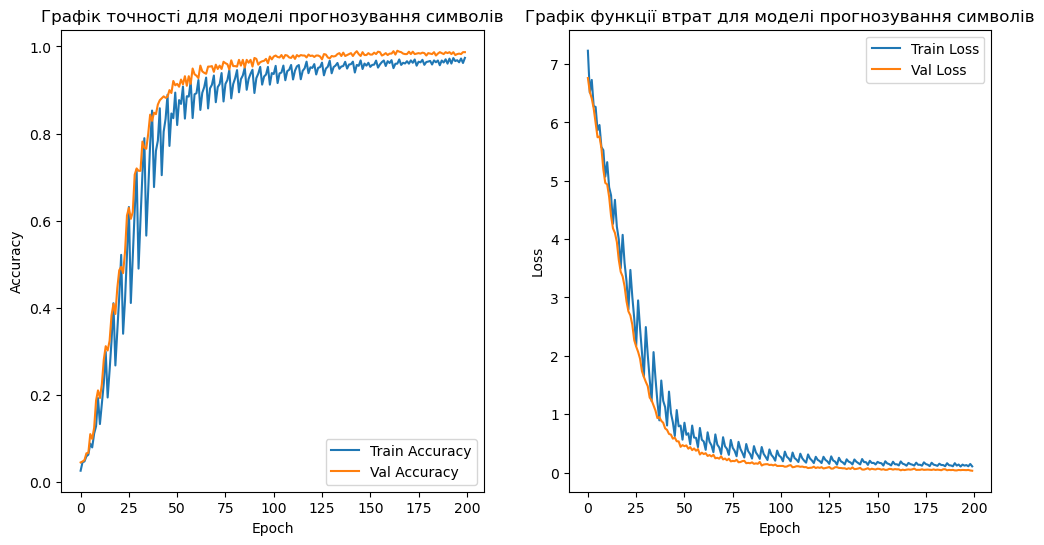

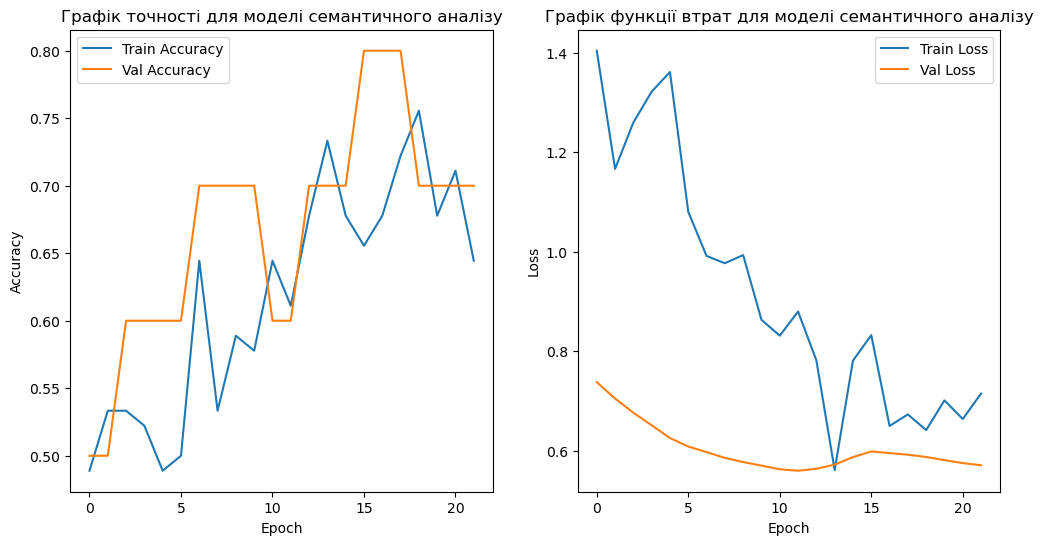

In [21]:
# Відображення графіків точності та втрат для генерації тексту
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Train Accuracy')
plt.plot(history_combined['val_accuracy'], label='Val Accuracy')
plt.title('Графік точності для моделі прогнозування символів')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Train Loss')
plt.plot(history_combined['val_loss'], label='Val Loss')
plt.title('Графік функції втрат для моделі прогнозування символів')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Відображення графіків точності та втрат для аналізу настрою
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_sent.history['accuracy'], label='Train Accuracy')
plt.plot(history_sent.history['val_accuracy'], label='Val Accuracy')
plt.title('Графік точності для моделі семантичного аналізу')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sent.history['loss'], label='Train Loss')
plt.plot(history_sent.history['val_loss'], label='Val Loss')
plt.title('Графік функції втрат для моделі семантичного аналізу')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()